In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import networkx as nx
from glob import glob
from pathlib import Path
import json
from tqdm import tqdm
from math import floor, ceil

In [2]:
with open("../data/edge_list_dict.json") as src:
    node_degrees = json.load(src)
    
with open("../data/edge_list_weights_dict.json") as src:
    node_weights = json.load(src)
    
filtered_node_weights = {k:v for k,v in node_weights.items() if v < 2999951}
    
node_traits = pd.read_table("/project/biocomplexity/nssac/EpiHiperSynPop/v1.9.0/usa_va_2017_SynPop/va_persontrait_epihiper.txt", low_memory=True, sep=",", usecols=[0,2,3,5], header=1)
node_age = node_traits.set_index("pid")["age"].to_dict()

base = Path("/scratch/jho5ze/bionets/epihiper/data/output/")
experiment = "exp5"
scenarios = sorted(glob(str(base / experiment / "*")))
replicates = sorted([i for i in glob(str(base / experiment / scenarios[0] / "*")) if "replicate" in i], key = lambda x: int(x.split("_")[-1]))
len(replicates)

60

In [19]:
np.quantile(np.array(sorted(list(node_degrees.values()))), 0.75)

132.0

(array([1161678., 1152078., 1024296.,  704704.,  549912.,  424464.,
         343953.,  280329.,  237258.,  203920.,  175883.,  153479.,
         132769.,  115418.,   98809.,   85567.,   73416.,   62473.,
          53128.,   44852.,   37603.,   31026.,   25475.,   20561.,
          16515.,   13178.,   10309.,    7879.,    6142.,    4784.]),
 array([      0.,  166664.,  333328.,  499992.,  666656.,  833320.,
         999984., 1166648., 1333312., 1499976., 1666640., 1833304.,
        1999968., 2166632., 2333296., 2499960., 2666624., 2833288.,
        2999952., 3166616., 3333280., 3499944., 3666608., 3833272.,
        3999936., 4166600., 4333264., 4499928., 4666592., 4833256.,
        4999920.]),
 <BarContainer object of 30 artists>)

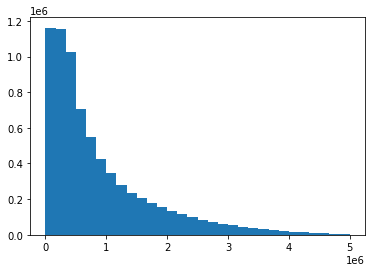

In [12]:
plt.hist(filtered_node_weights.values(), bins=30)

In [3]:
degree_dist_pop = pd.Series([i//50 for i in node_degrees.values()]).value_counts().to_dict()
weight_dist_pop = pd.Series([i//166664 for i in filtered_node_weights.values()]).value_counts().to_dict()

In [7]:
sum(degree_dist_pop.values()) / 4

1901357.5

In [8]:
degree_dist_pop

{1: 2524316,
 0: 1850072,
 2: 1806175,
 3: 855983,
 4: 356877,
 5: 132944,
 6: 47450,
 7: 17946,
 8: 7234,
 9: 3195,
 10: 1554,
 11: 756,
 12: 421,
 13: 227,
 14: 120,
 15: 62,
 16: 39,
 17: 29,
 18: 11,
 19: 9,
 20: 5,
 22: 2,
 23: 1,
 21: 1,
 25: 1}

In [14]:
(1806175 - (1+1+1+2+5+9+11+29+39+62+120+227+421+756+1554+3195+7234+17946+47450+132944+356877+855983)) / 1806175

0.21111354104668706

In [4]:
degree_dist_popt_infected_count(col, total_modifier=1, weight=False):
    ret_col = col.copy().astype(float)
    total = weight_dist_pop[int(col.name)] * total_modifier if weight else degree_dist_pop[int(col.name)] * total_modifier
    max_val = 0
    for ix in col.index:
#         value = (total - col[ix]) / total
        ret_col[ix] = 1 - ((total - col[ix]) / total)
    return ret_col
    
def get_suscep_remaining(col, total_modifier=1):
    ret_col = col.copy().astype(float)
    total = degree_dist_pop[col.name] * total_modifier
    max_val = 0
    for ix in col.index:
#         value = (total - col[ix]) / total
        ret_col[ix] = ((total - col[ix]) / total)
    return ret_col
    
def show_bar_values(ax, weight=False):        
    for p in ax.patches:
        _x = p.get_x() + p.get_width() 
        _y = p.get_y() + p.get_height() / 2
        value = int(p.get_width())
#         value = '{:.2f}'.format(round(p.get_width(), 0))
        if weight:
            ax.text(600000, _y, value, ha="center") 
        else:
            ax.text(1300000, _y, value, ha="center") 
#         ax.text(0, _y, value, ha="center") 
    
def scenario_to_title(scenario):
    scenario = scenario.split("/")[-1]
    scenario = scenario.replace("tau_", "Variant 1: ")
    scenario = scenario.replace("_var2_1.4_seed2p", "")
    scenario = scenario.replace("_5", ", Location: 5")
    scenario = scenario.replace("_seed2t_", ", Emergence Day: ")
#     scenario = scenario.replace("", "")
    return scenario
scenario_to_title(scenarios[6])
    

'Variant 1: 0.02, Location: 51, Emergence Day: 120'

In [8]:
normalize=True
weight=False
replicate = None
scenario = scenarios[0]

replicates = sorted([i for i in glob(str(base / experiment / scenario / "*")) if "replicate" in i], key = lambda x: int(x.split("_")[-1]))

if replicate is None:
    passed_replicates = [replicate for replicate in replicates if check_replicate_passed(scenario, replicate, experiment=experiment)]
else:
    passed_replicates = [replicate]

var_data = []
#     print(len(passed_replicates))
for ix, replicate in enumerate(passed_replicates):
    variant_data = pd.read_csv(f"../data/processed_{experiment}/{scenario.split('/')[-1]}_{replicate.split('/')[-1]}_variant_data.csv")
    if weight:
        variant_data = variant_data[variant_data.pid.isin(filtered_node_weights)]
        variant_data["node_weight"] = variant_data.pid.apply(lambda row: filtered_node_weights[str(row)])
        variant_data["class"] = variant_data.node_weight.apply(lambda row: row // 166664)
    else:
        variant_data["class"] = variant_data.node_degree.apply(lambda row: row // 50)
#     split_variant_data = variant_data.groupby(["tick", "variant", "class"]).count().reset_index().pivot(index =["variant", "tick"], columns="class", values="pid")
#     var_data.append(split_variant_data)
#     if ix > 2:
    break
# var_data = pd.concat(var_data)
# if normalize:
#     var_data = var_data.groupby(["variant", "tick"]).median() #.groupby("variant").cumsum()
#     var_data = (var_data.T / var_data.sum(axis=1)).T
# else:
#     var_data = var_data.groupby(["variant", "tick"]).sum().groupby("variant").cumsum()
#     var_data = var_data.apply(lambda col: get_infected_count(col, total_modifier=len(passed_replicates), weight=weight))
# if weight:
#     var_data.columns = [f"{int(i)*166664} - {(int(i)+1)*166664 - 1}" for i in var_data.columns]
#     var_data = var_data.rename(columns={"0 - 166663":"Weight\n0 - 166663"})
# else:
#     var_data = var_data[[c for c in var_data.columns if degree_dist_pop[c] > 30*len(passed_replicates)]]
#     var_data.columns = [f"{int(i)*50} - {(int(i)+1)*50 - 1}" for i in var_data.columns]
#     var_data = var_data.rename(columns={"0 - 49":"Degree\n0 - 49"})

In [9]:
vs = variant_data.groupby(["tick", "variant", "class"]).count().reset_index().pivot(index =["variant", "tick"], columns="class", values="pid")
v1 = vs.loc["var1"]
v2 = vs.loc["var2"]
(v2 / v1)

class,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
tick,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.773438,0.750856,0.734155,0.841497,0.941448,0.928058,0.849558,0.589286,1.176471,0.666667,0.500,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
396,0.792683,0.808333,0.746733,0.839865,0.985871,0.896679,0.834783,0.645161,1.105263,0.625000,0.625,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
397,0.800781,0.812245,0.754447,0.829859,1.021036,0.913043,0.906780,0.660714,0.952381,0.625000,0.625,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
def plot_pop_bar(bar_ax, weight=False):
    if weight:
        name = "Degree Weight"
        bars = pd.Series(weight_dist_pop).sort_index().reset_index()
        
    else:
        name = "Degree"
        bars = pd.Series({k:v for k,v in degree_dist_pop.items() if v > 30}).sort_index().reset_index()
        
    bars = bars.rename(columns={0:"Total Count in Population", "index":name})
    bars = bars[bars["Total Count in Population"] > 30]
    bars[name] = bars[name].astype(str)
    sns.barplot(data=bars, x = "Total Count in Population", y=name, ax=bar_ax, color=sns.color_palette()[0])
    bar_ax.invert_xaxis()
    bar_ax.tick_params(axis="y", which="both", labelleft=False, left=False)
    # bar_ax.tick_params(axis="x", which="both", labeltop=True, top=True, bottom=False, labelbottom=False)
    bar_ax.xaxis.set_label_position("top")
#     bar_ax.yaxis.set_label_position("left")
    bar_ax.set_ylabel("")
    # bar_ax = gs[0:2, :]
    show_bar_values(bar_ax, weight=weight)
    
def check_replicate_passed(scenario, replicate, var_num="2", experiment="exp5"):
    summary = pd.read_csv(base / experiment / scenario.split("/")[-1] / replicate.split("/")[-1] / "outputSummary.csv.gz")
    if summary[[f"var{var_num}Isymp[current]", f"var{var_num}Iasymp[current]"]].iloc[-1].sum() < 1:
        return False
    else:
        return True
    
def plot_susceptible_hmap(heat_ax, susc_data, bottom=True):
    sns.heatmap(susc_data.T, ax=heat_ax, vmax=1, vmin=0.8)
    if bottom:
        heat_ax.set_xlabel("Day in Simulation")
    else:
        ax.set_xlabel("")
    heat_ax.set_ylabel("% Of Nodes Remaining in Susceptible")
    heat_ax.yaxis.set_label_position("right")

def get_susceptible_data(scenario, replicate=None, experiment="exp5"):
    if replicate is not None:
        replicate = replicate.split("/")[-1]
        susc_data = pd.read_csv(f"../data/processed_{experiment}/{scenario}_{replicate}_susc_data.csv")
        susc_data = susc_data[[c for c in susc_data.columns if susc_data[c].max() > 30]]
        bars = susc_data.iloc[0] 
        bars = bars.reset_index().rename(columns={0:"Total Count in Population", "index":"Degree"})
#         return bars
        susc_data = susc_data.apply(lambda col: get_infected_count(col))
        susc_data.columns = [f"{int(i)*50} - {(int(i)+1)*50 - 1}" for i in susc_data.columns]
        susc_data = susc_data.rename(columns={"0 - 49":"Degree\n0 - 49"})
    
    else:
        replicates = sorted([i for i in glob(str(base / experiment / scenario / "*")) if "replicate" in i], key = lambda x: int(x.split("_")[-1]))
        suscs = []
        pass_replicates = 0
        for replicate in replicates:
            if not check_replicate_passed(scenario, replicate, experiment=experiment):
                continue
            pass_replicates += 1
            replicate = replicate.split("/")[-1]
            susc_data = pd.read_csv(f"../data/processed_{experiment}/{scenario}_{replicate}_susc_data.csv")
            suscs.append(susc_data)
#         print(pass_replicates)
        susc_data = pd.concat(suscs)
        susc_data = susc_data.groupby(susc_data.index).sum()
        susc_data = susc_data[[c for c in susc_data.columns if susc_data[c].max() > 30*pass_replicates]]

        susc_data = susc_data.apply(lambda col: get_infected_count(col, total_modifier=pass_replicates))
        susc_data.columns = [f"{int(i)*50} - {(int(i)+1)*50 - 1}" for i in susc_data.columns]
        susc_data = susc_data.rename(columns={"0 - 49":"Degree\n0 - 49"})
        
    return susc_data

def get_variant_data(scenario, replicate=None, experiment="exp5", normalize=False, weight=False, prevalence=False):
    replicates = sorted([i for i in glob(str(base / experiment / scenario / "*")) if "replicate" in i], key = lambda x: int(x.split("_")[-1]))
    
    if replicate is None:
        passed_replicates = [replicate for replicate in replicates if check_replicate_passed(scenario, replicate, experiment=experiment)]
    else:
        passed_replicates = [replicate]
    
    var_data = []
#     print(len(passed_replicates))
    for ix, replicate in enumerate(passed_replicates):
#         if ix > 0:
#             break
        variant_data = pd.read_csv(f"../data/processed_{experiment}/{scenario.split('/')[-1]}_{replicate.split('/')[-1]}_variant_data.csv")
        if weight:
            variant_data = variant_data[variant_data.pid.isin(filtered_node_weights)]
            variant_data["node_weight"] = variant_data.pid.apply(lambda row: filtered_node_weights[str(row)])
            variant_data["class"] = variant_data.node_weight.apply(lambda row: row // 166664)
            split_variant_data = variant_data.groupby(["tick", "variant", "class"]).count().reset_index().pivot(index =["variant", "tick"], columns="class", values="pid")
            
        else:
            variant_data["class"] = variant_data.node_degree.apply(lambda row: row // 50)
#             print(variant_data["class"].value_counts())
            split_variant_data = variant_data.groupby(["tick", "variant", "class"]).count().reset_index().pivot(index =["variant", "tick"], columns="class", values="pid")
        
        if prevalence:
            v1 = split_variant_data.loc["var1"]
            v2 = split_variant_data.loc["var2"]
            v2_prev = (v2 / (v1 + v2))
            v2_prev = v2_prev.where(~(v2_prev.isna() & v2.notna()), other = 0)
            v2_prev["variant"] = "var2"
            v1_prev = (v1 / (v1 + v2))
            v1_prev = v1_prev.where(~(v1_prev.isna() & v1.notna()), other = 1)
            v1_prev["variant"] = "var1"
            split_variant_data = pd.concat([v1_prev, v2_prev])
        
        var_data.append(split_variant_data)

    var_data = pd.concat(var_data)
    
    if normalize:
        var_data = var_data.groupby(["variant", "tick"]).median() #.groupby("variant").cumsum()
        var_data = (var_data.T / var_data.sum(axis=1)).T
    elif prevalence:
        var_data = var_data.groupby(["variant", "tick"]).median()
#         var_data.loc["var1"] = var_data.loc["var1"].fillna(1)
#         var_data.loc["var2"] = var_data.loc["var2"].fillna(0)
    else:
        var_data = var_data.groupby(["variant", "tick"]).sum().groupby("variant").cumsum()
        var_data = var_data.apply(lambda col: get_infected_count(col, total_modifier=len(passed_replicates), weight=weight))
        
    if weight:
        var_data.columns = [f"{(int(i)+1)*166664 - 1}" for i in var_data.columns]
        var_data = var_data.rename(columns={"166663":"Weight\n0 - 166663"})
    else:
#         print(var_data.columns)
        var_data = var_data[[c for c in var_data.columns if degree_dist_pop[c] > 30]]
        var_data.columns = [f"{int(i)*50} - {(int(i)+1)*50 - 1}" for i in var_data.columns]
        var_data = var_data.rename(columns={"0 - 49":"Degree\n0 - 49"})
    return var_data.loc["var1"], var_data.loc["var2"].reindex(var_data.loc["var1"].index)

def plot_variant_hmap(ax, var_data, vmax=None, vmin=None, bottom=True):
    sns.heatmap(var_data.T, ax=ax, cmap="rocket_r", vmax=vmax, vmin=vmin)
    if bottom:
        ax.set_xlabel("Day in Simulation")
    else:
        ax.set_xlabel("")
    ax.set_ylabel("% Of Nodes Infected by Variant by Tick Day")
    ax.yaxis.set_label_position("right")
    
#     split_variant_data = split_variant_data.groupby("variant").cumsum().apply(lambda col: get_infected_count(col))

In [23]:
x = get_variant_data(scenarios[0], replicate=replicates[0], prevalence=True)

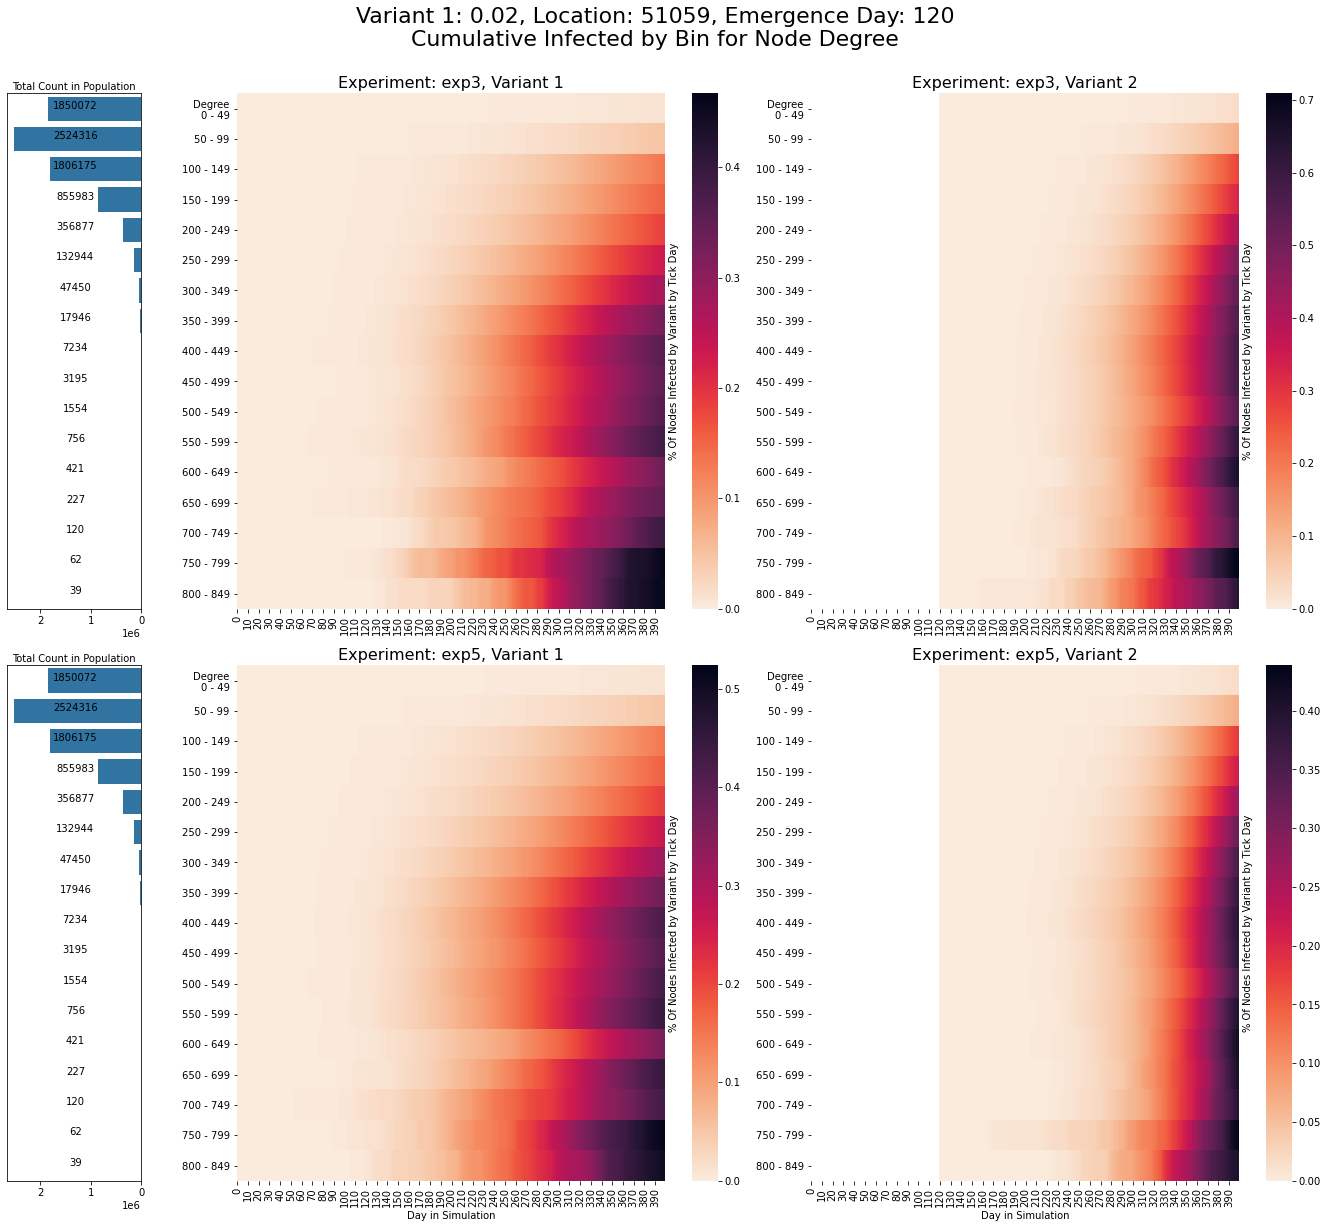

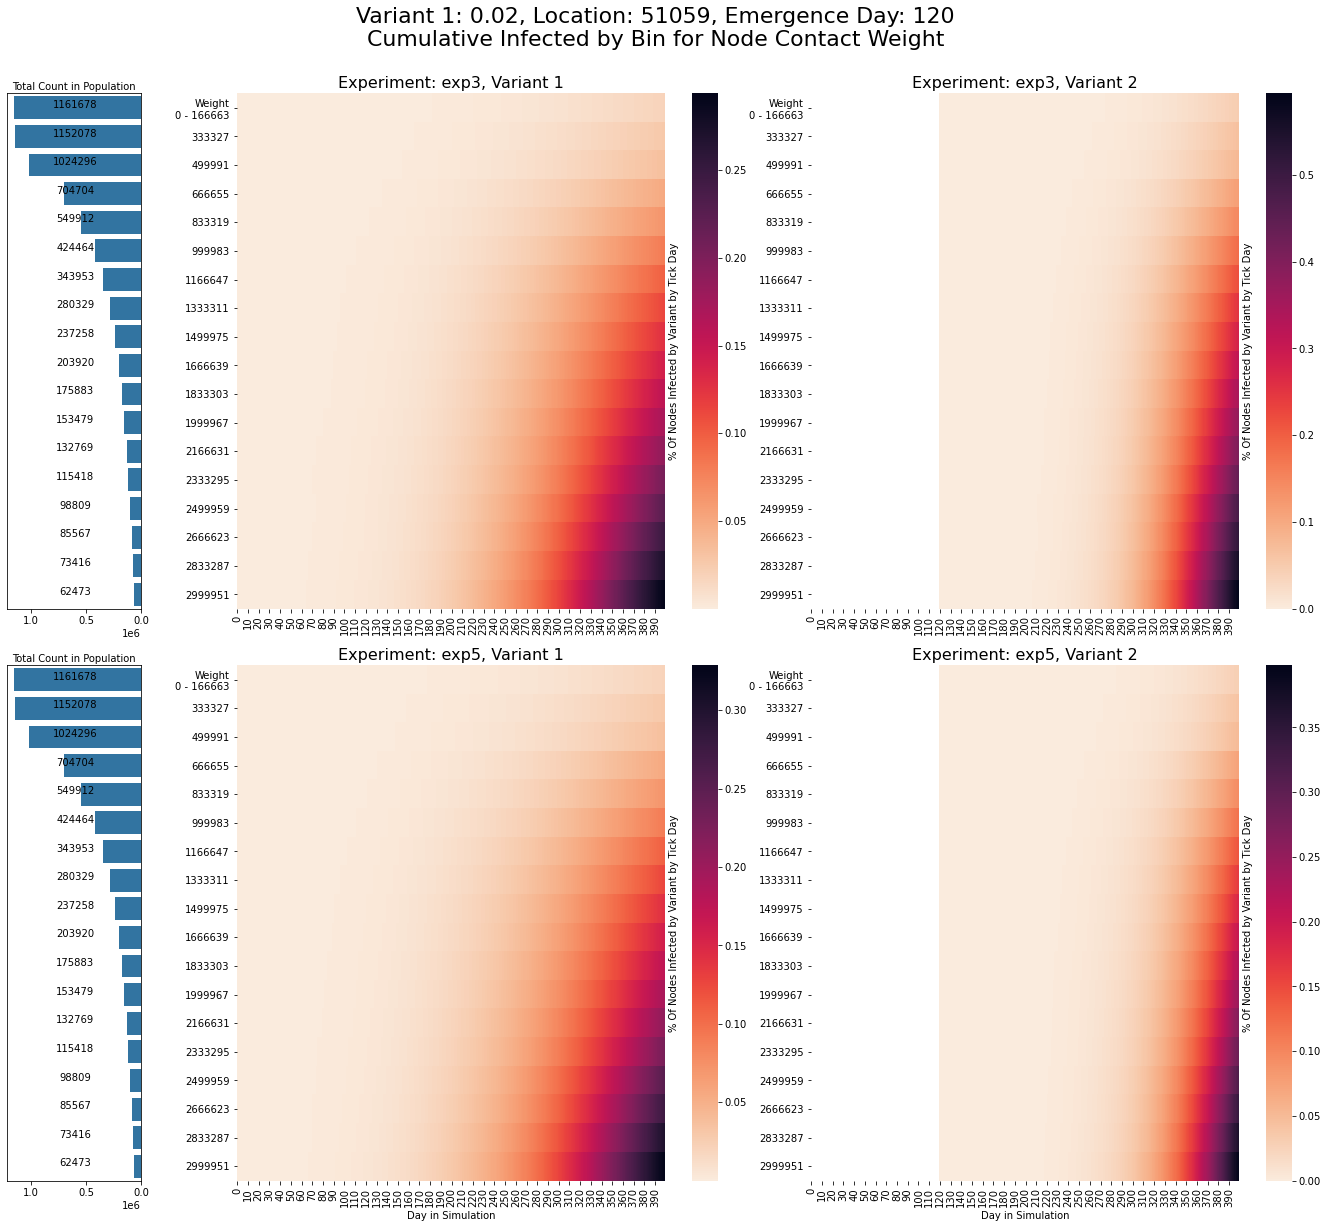

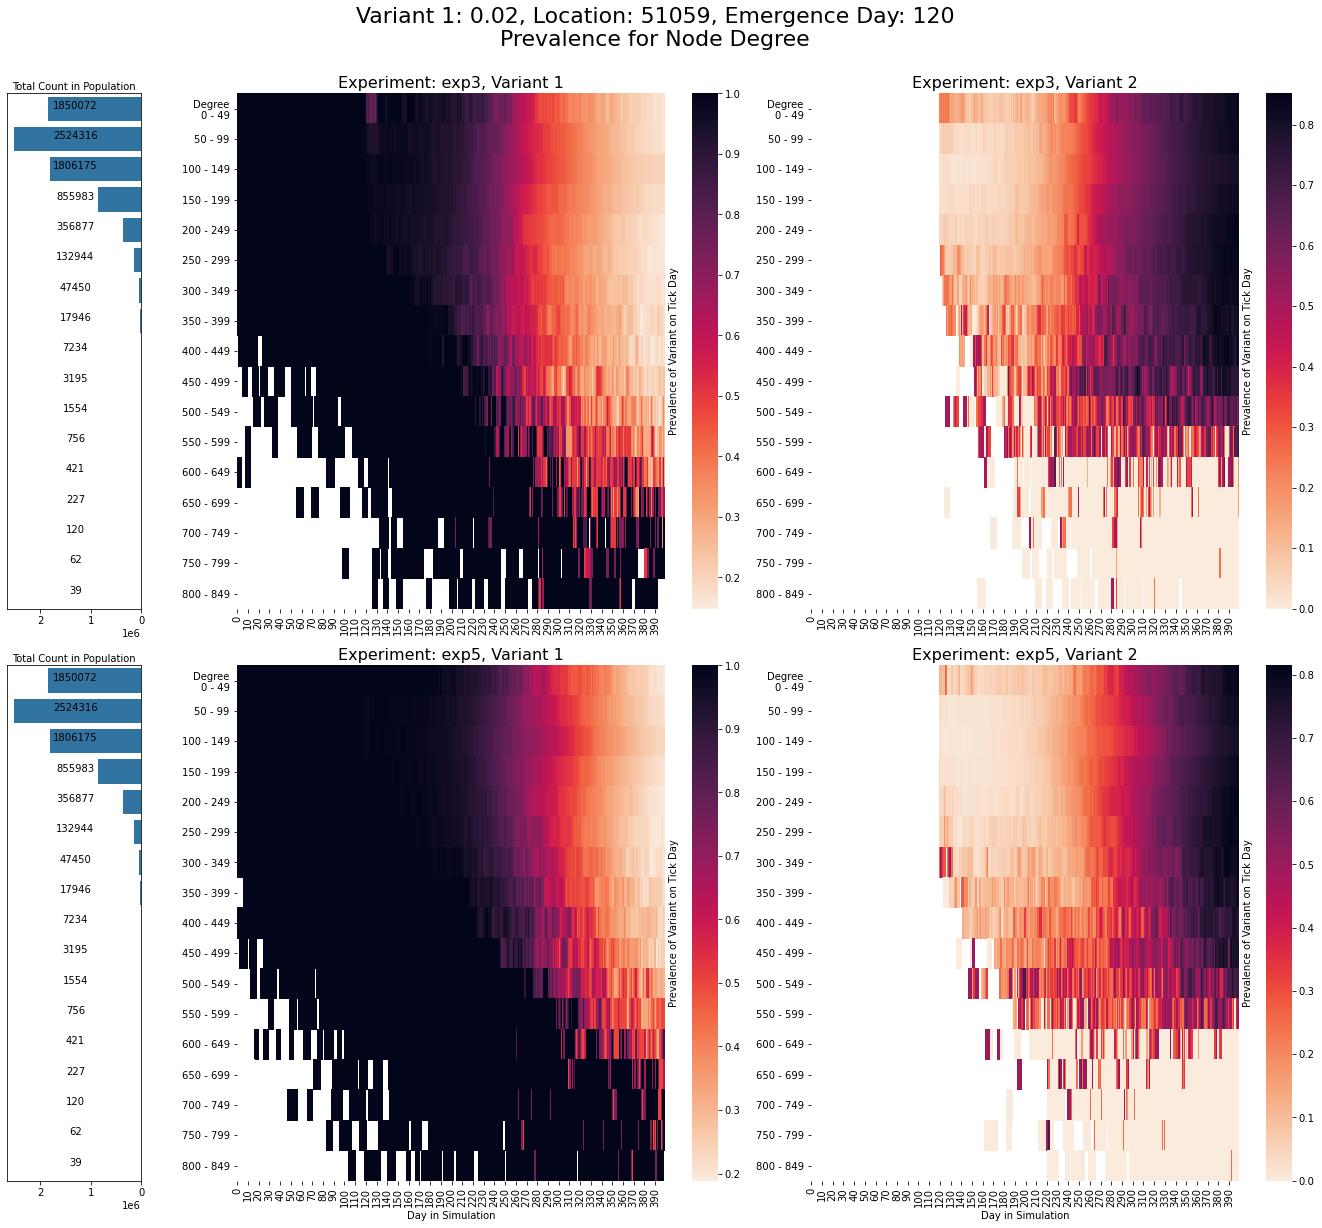

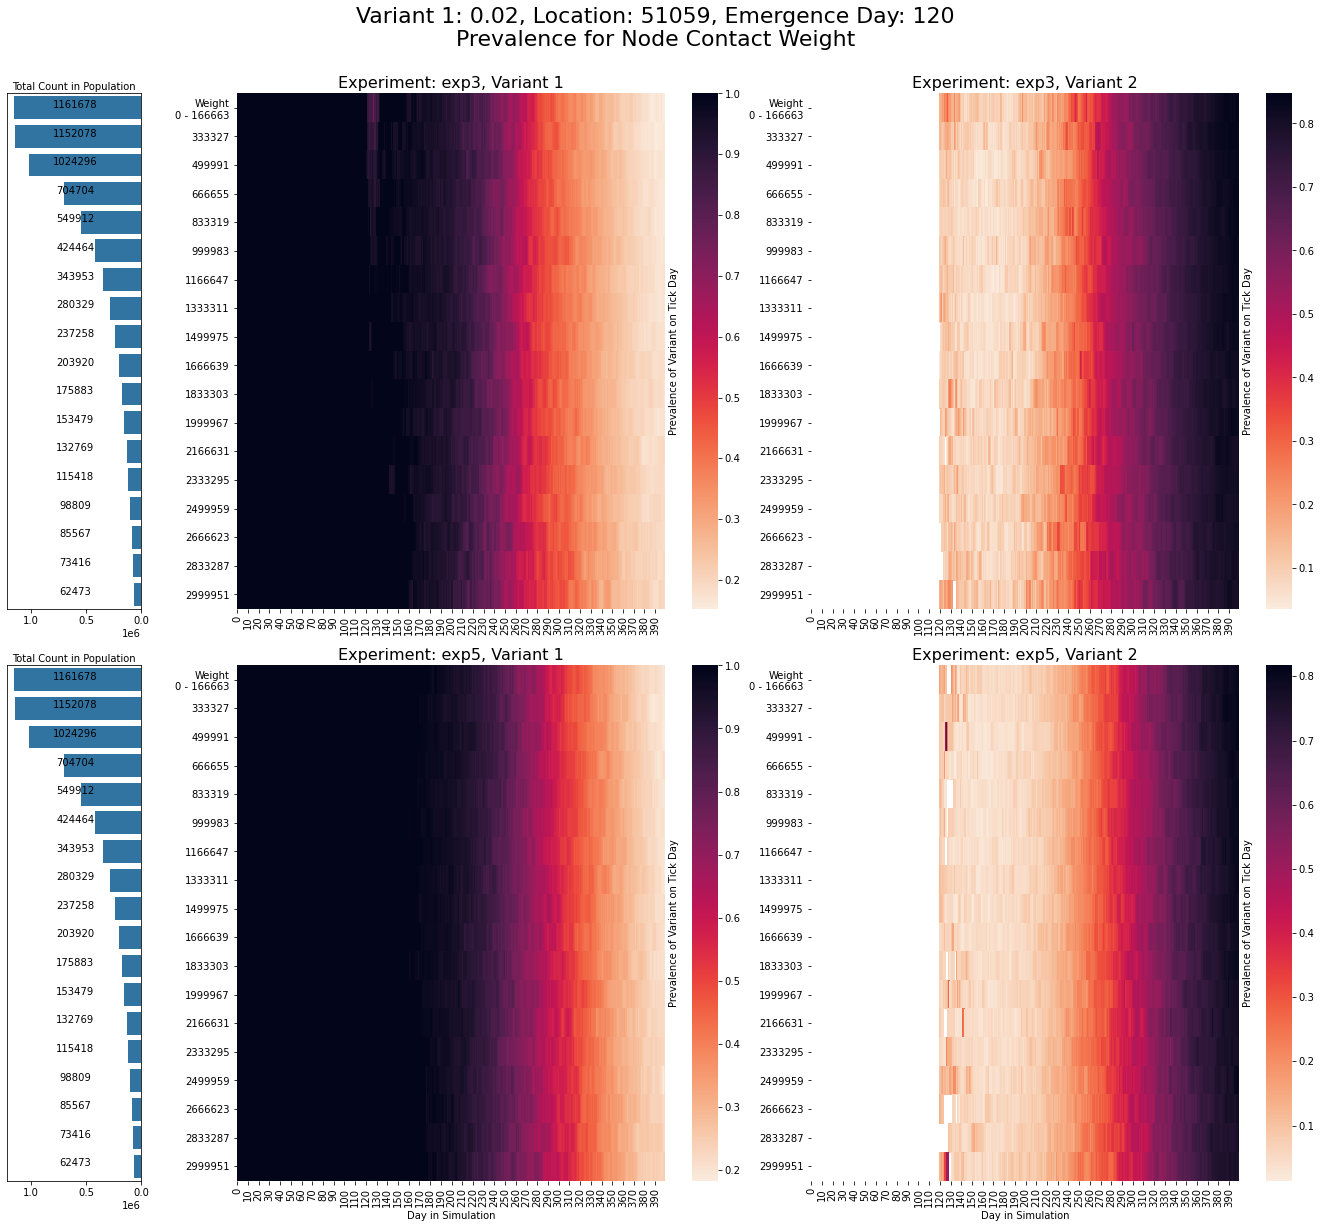

In [6]:
scenario = scenarios[0].split("/")[-1]



normalize_columns=False
weight=False
prevalence=True


# sorted_scenarios = sorted(scenarios, key = lambda row: row.replace("90", "100"))   
for prevalence in range(2):
    for weight in range(2):
        fig = plt.figure(figsize=(24, 20))
        gs = fig.add_gridspec(nrows=20, ncols=24)
        for ix, experiment in enumerate(["exp3", "exp5"]):
            norm_str = "_column_normalized_not_cumulative" if normalize_columns else ""
            weight_str = "_degree_weight" if weight else ""
            prev_str = "_prevalence" if prevalence else ""
        #     scenario = scenario.split("/")[-1]
            scenario_title = f"{experiment}, " + scenario_to_title(scenario)
        #     susc_data, bars = get_susceptible_data(scenario, experiment=experiment)

            for var_ix, var_data in enumerate(get_variant_data(scenario, experiment=experiment, normalize=normalize_columns, weight=weight, prevalence=prevalence)):

                bottom = 10 * (ix)
                top = 10 * ((ix) + 1)
                left = 4 + 10 * (var_ix)
                right = 4 + 10 * ( (var_ix) + 1)

                title = f'Experiment: {experiment}, Variant {var_ix+1}'


                if var_ix == 0:
                    bar_ax = fig.add_subplot(gs[bottom:top, 0:3])
                    plot_pop_bar(bar_ax, weight=weight)

                heat_ax = fig.add_subplot(gs[bottom:top, left:right])
                if normalize_columns:
                    plot_variant_hmap(heat_ax, var_data, bottom=ix) #, vmax=0.4, vmin=0)
                    heat_ax.set_ylabel("% Of Nodes Infected by Variant on Tick Day")

                else:
                    if weight:
                        plot_variant_hmap(heat_ax, var_data, bottom=ix) #, vmax=0.03, vmin=0)
                    else:
                        plot_variant_hmap(heat_ax, var_data, bottom=ix) #, vmax=0.05, vmin=0)
                        
                    if prevalence:
                        heat_ax.set_ylabel("Prevalence of Variant on Tick Day")
                        

                heat_ax.set_title(title, fontsize=16)
        #     print(ix)
        #     if ix > 7:
        #         break

        plt.subplots_adjust(hspace=120, wspace=2)
        sup_norm = "Normalized by Day" if normalize_columns else "Cumulative Infected by Bin"
        sup_weight = " for Node Contact Weight" if weight else " for Node Degree"
        if prevalence:
            title = "\nPrevalence" + sup_weight
        else:
            title = f"\n{sup_norm}{sup_weight}"
        plt.suptitle(scenario_to_title(scenario) + title, y=0.94, fontsize=22)
#         break
        
#     break
        # plt.tight_layout()        
        plt.savefig(f"../plots/exp3_exp5_variant_infections_comparison_heatmap{norm_str}{weight_str}{prev_str}.png", dpi=100, facecolor="white", bbox_inches="tight")

<AxesSubplot:xlabel='tick'>

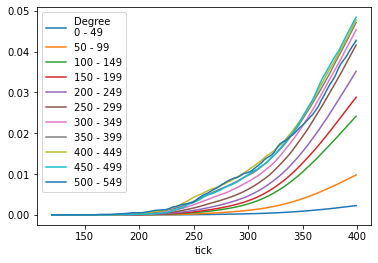

In [24]:
var_data.plot() #(var_data.T / var_data.sum(axis=1)).T

In [236]:
def plot_susceptible_summary(sc_ix = 0, rep_ix=None):
    scenario = scenarios[sc_ix].split("/")[-1]
    scenario_title = scenario_to_title(scenario)
    if rep_ix is not None:
        
        title = f"Susceptible Population Over Time by Degree\n{scenario_title} {replicate}"
        
        susc_data = get_susceptible_data(scenario, replicate=replicates[rep_ix])
    else:
        
        title = f"Susceptible Population Over Time by Degree\n{scenario_title} - All Replicates"
        
        susc_data = get_susceptible_data(scenario)
        
    fig = plt.figure(figsize=(14, 10))
    gs = fig.add_gridspec(nrows=10, ncols=14)
    bar_ax = fig.add_subplot(gs[:, 0:3])
    
    plot_pop_bar(bar_ax)

    heat_ax = fig.add_subplot(gs[:, 4:])
    plot_susceptible_hmap(heat_ax, susc_data)
    
    plt.subplots_adjust(wspace=0.4)
    
    plt.suptitle(title, y=0.95, fontsize=16)
    plt.savefig(f"../plots/{experiment}/{experiment}_susceptible_summary_{scenario}.png", dpi=100, facecolor="white", bbox_inches="tight")



In [235]:
for ix in range(6, 18):
    plot_susceptible_summary(sc_ix=ix)    
    break
# plot_susceptible_summary(sc_ix=0)

FileNotFoundError: [Errno 2] No such file or directory: '../data/processed_exp5/tau_0.02_var2_1.4_seed2p_51_seed2t_120_replicate_21_susc_data.csv'

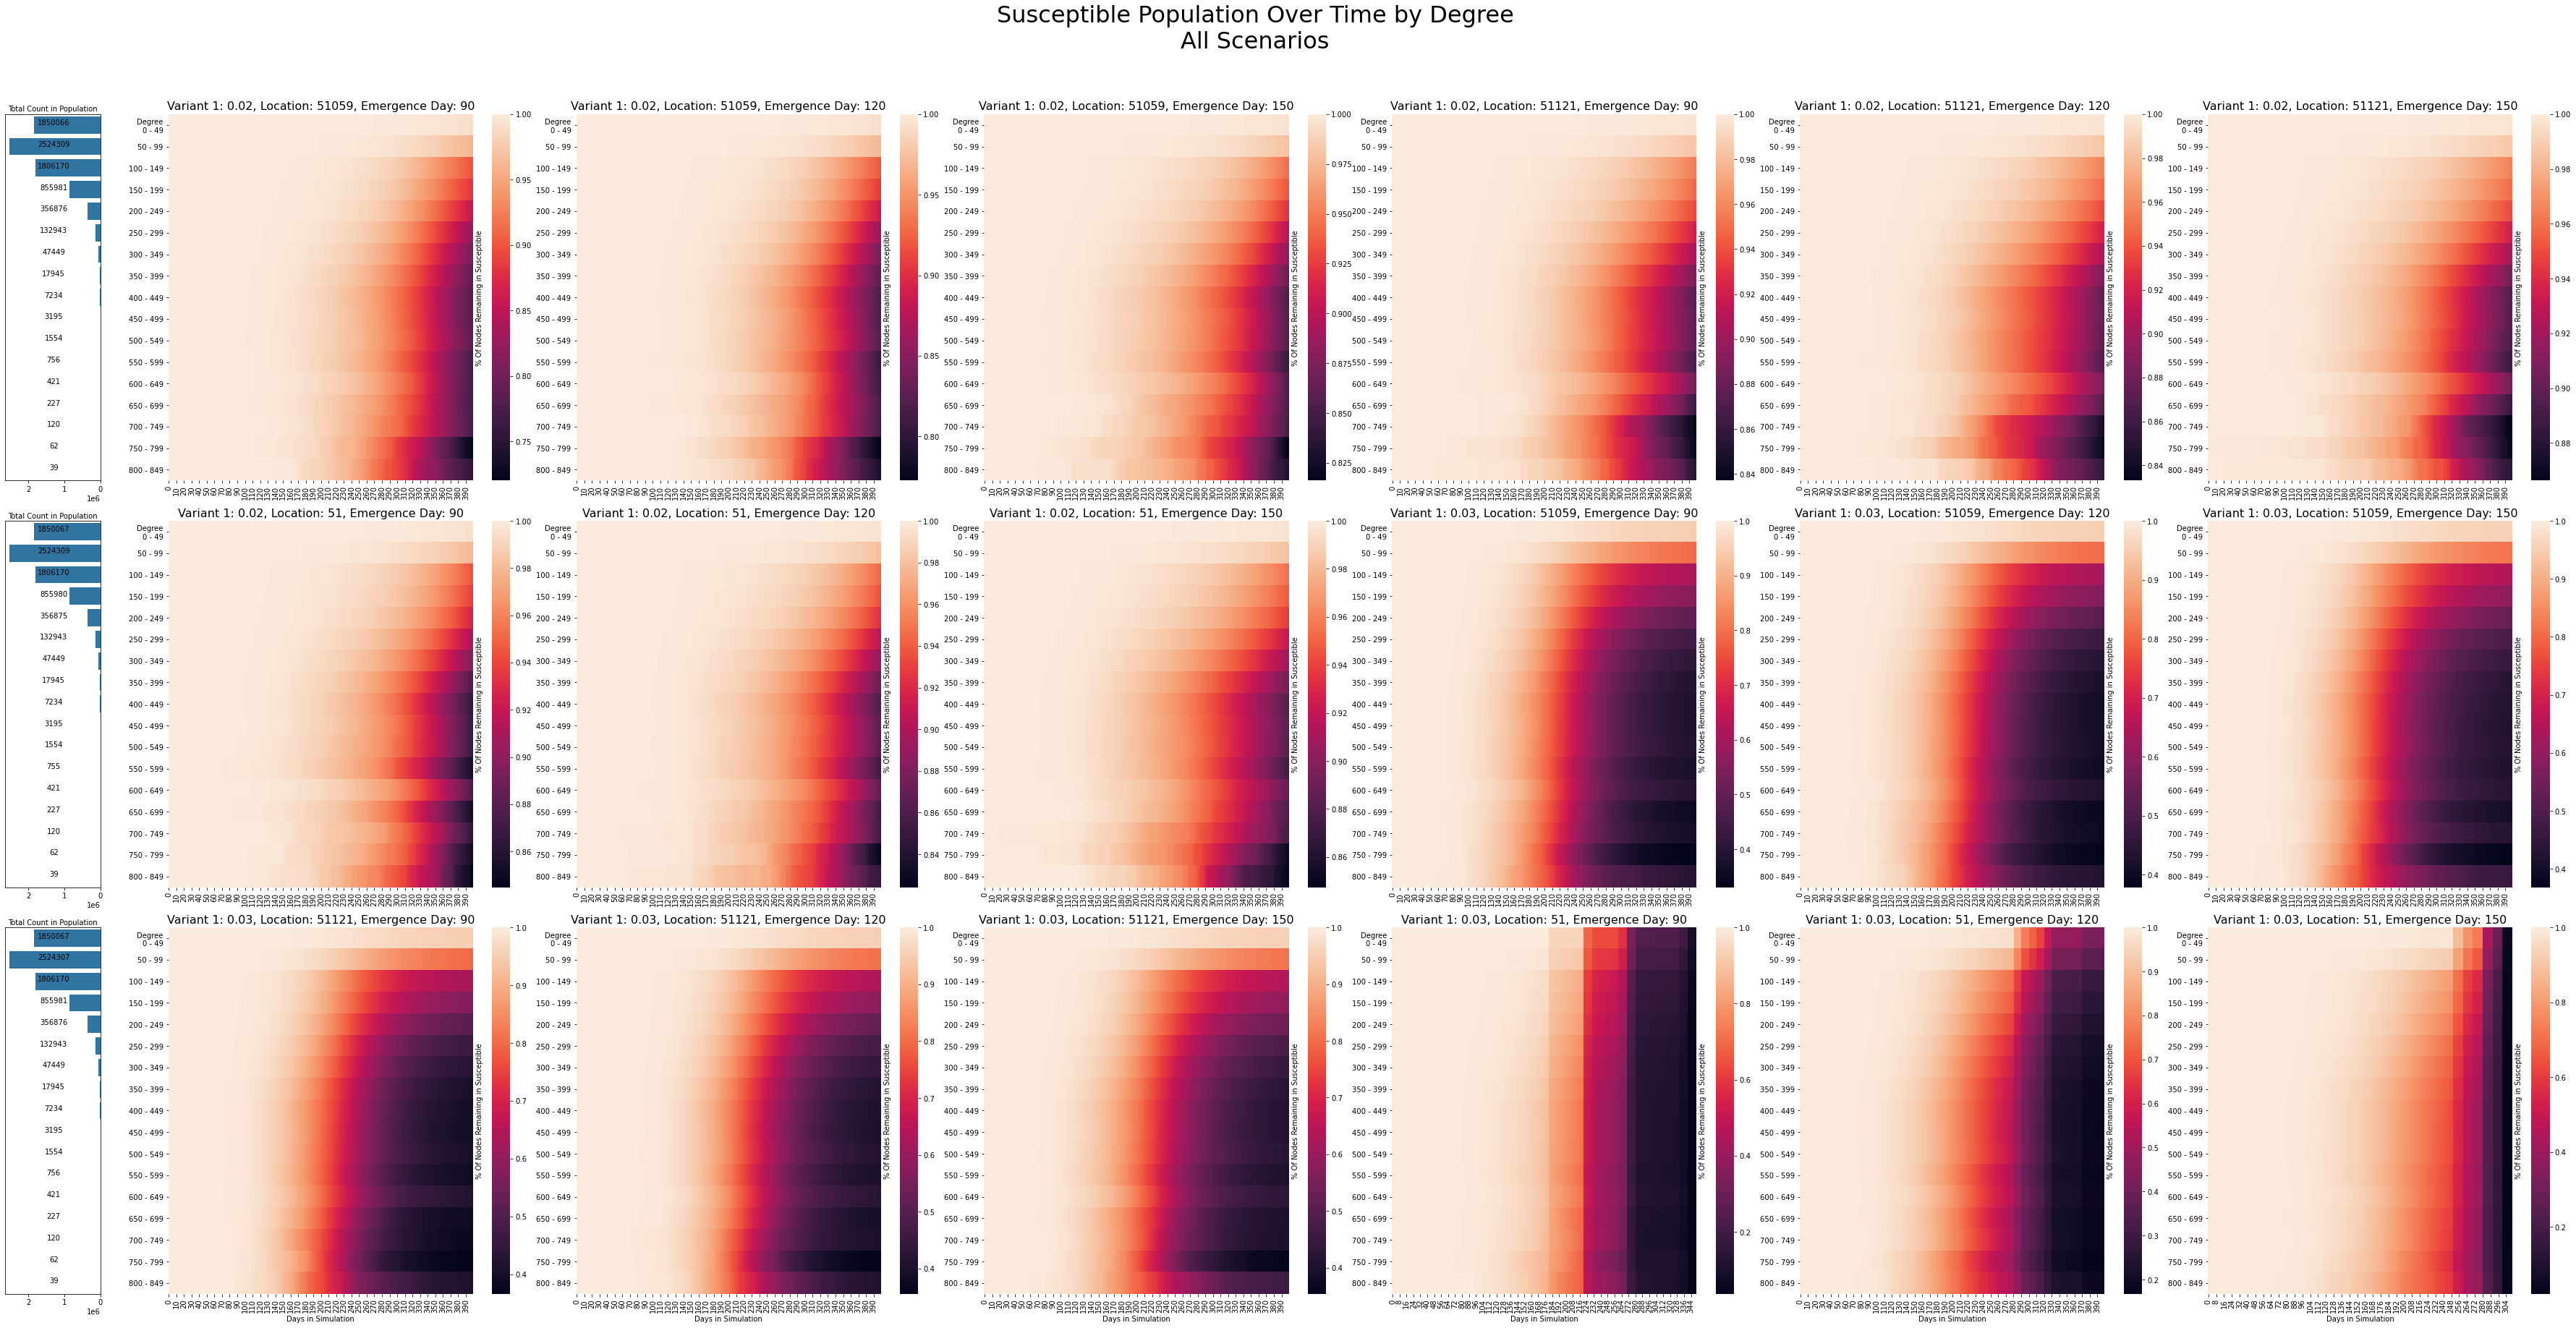

In [74]:
fig = plt.figure(figsize=(64, 30))
gs = fig.add_gridspec(nrows=30, ncols=64)

sorted_scenarios = sorted(scenarios, key = lambda row: row.replace("90", "100"))    

for ix, scenario in enumerate(sorted_scenarios):
    scenario = scenario.split("/")[-1]
    scenario_title = scenario_to_title(scenario)
    
    bottom = 10 * (ix // 6)
    top = 10 * ((ix // 6) + 1)
    left = 4 + 10 * (ix % 6)
    right = 4 + 10 * ( (ix % 6) + 1)
    
    title = f"{scenario_title}"

    susc_data, bars = get_susceptible_data(scenario)
        
    if ix % 6 == 0:
        bar_ax = fig.add_subplot(gs[bottom:top, 0:3])
        plot_pop_bar(bar_ax, bars)

    heat_ax = fig.add_subplot(gs[bottom:top, left:right])
    sns.heatmap(susc_data.T, ax=heat_ax)
    if top == 30:
        heat_ax.set_xlabel("Days in Simulation")
    else:
        heat_ax.set_xlabel("")
    heat_ax.set_ylabel("% Of Nodes Remaining in Susceptible")
    heat_ax.yaxis.set_label_position("right")
    
    heat_ax.set_title(title, fontsize=16)
#     print(ix)
#     if ix > 7:
#         break
        
plt.subplots_adjust(hspace=100, wspace=2)
#         plt.tight_layout()        
#     plt.savefig(f"../plots/susceptible_summary_{scenario}.png", dpi=100, facecolor="white", bbox_inches="tight")
plt.suptitle("Susceptible Population Over Time by Degree\nAll Scenarios", x=0.5, y=0.95, fontsize=32)
plt.savefig(f"../plots/{experiment}/{experiment}_susceptible_summary_for_all_scenarios.png", dpi=100, facecolor="white", bbox_inches="tight")


In [22]:
bins = {i:0 for i in range(ceil(max(node_degrees.values()) / 50))}


scenario = scenarios[0].split("/")[-1]
replicate = replicates[0].split("/")[-1]
susc_data = pd.read_csv(f"../data/processed_{experiment}/{scenario}_{replicate}_susc_data.csv")
susc_data = susc_data[[c for c in susc_data.columns if susc_data[c].max() > 30]]
susc_data.columns = [f"{int(i)*50} - {(int(i)+1)*50 - 1}" for i in susc_data.columns]
bars = susc_data.iloc[0] 
bars = bars.reset_index().rename(columns={0:"Count", "index":"Degree"})
susc_data = susc_data.apply(lambda col: get_infected_count(col))
# susc_data.max()

In [163]:
suscs = []
for replicate in replicates:
    replicate = replicate.split("/")[-1]
    susc_data = pd.read_csv(f"../data/processed_{experiment}/{scenario}_{replicate}_susc_data.csv")
    suscs.append(susc_data)
susc_data = pd.concat(suscs)
susc_data = susc_data.groupby(susc_data.index).sum()
susc_data = susc_data[[c for c in susc_data.columns if susc_data[c].max() > 30*20]]
susc_data.columns = [f"{int(i)*50} - {(int(i)+1)*50 - 1}" for i in susc_data.columns]
bars = susc_data.iloc[0] / 20
bars = bars.reset_index().rename(columns={0:"Count", "index":"Degree"})
susc_data = susc_data.apply(lambda col: get_infected_count(col))

Text(0.5, 0.95, 'Susceptible Population Decline Over Time by Degree\ntau_0.02_var2_1.4_seed2p_51059_seed2t_120 replicate_20')

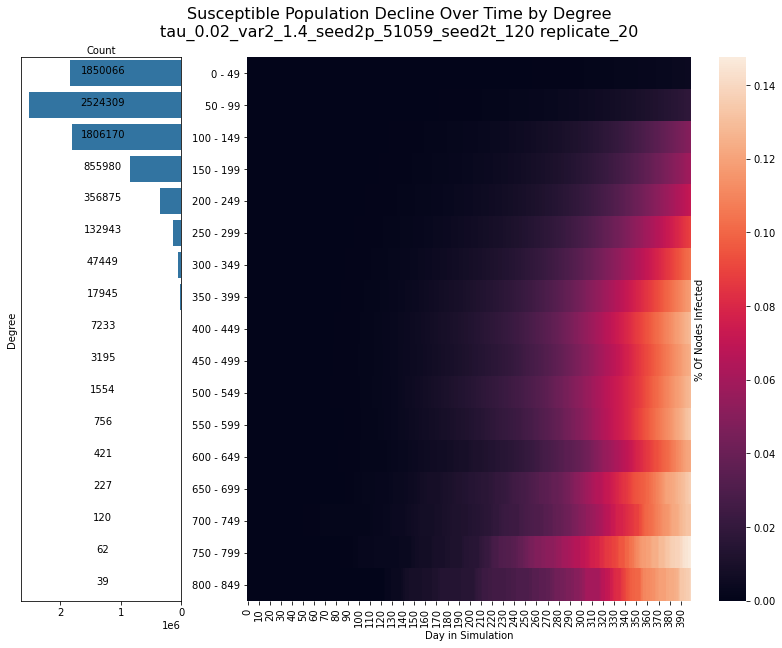

In [165]:
fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(nrows=10, ncols=14)
bar_ax = fig.add_subplot(gs[:, 0:3])
sns.barplot(data=bars, x = "Count", y="Degree", ax=bar_ax, color=sns.color_palette()[0])
bar_ax.invert_xaxis()
bar_ax.tick_params(axis="y", which="both", labelleft=False, left=False)
# bar_ax.tick_params(axis="x", which="both", labeltop=True, top=True, bottom=False, labelbottom=False)
bar_ax.xaxis.set_label_position("top")
# bar_ax = gs[0:2, :]
show_bar_values(bar_ax)

heat_ax = fig.add_subplot(gs[:, 4:])
sns.heatmap(susc_data.T, ax=heat_ax)
heat_ax.set_xlabel("Day in Simulation")
heat_ax.set_ylabel("% Of Nodes Infected")
heat_ax.yaxis.set_label_position("right")

plt.suptitle(f"Susceptible Population Decline Over Time by Degree\n{scenario} {replicate}", y=0.95, fontsize=16)
# plt.tight_layout()

<AxesSubplot:>

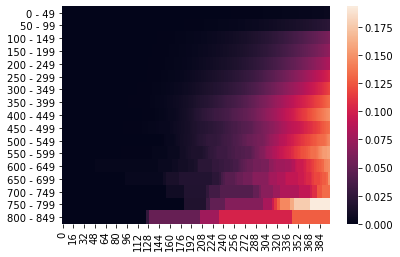

In [69]:
sns.heatmap(susc_data.T)

In [91]:
bars.reset_index()

,index,0
0,0 - 49,1850064
1,50 - 99,2524312
2,100 - 149,1806171
3,150 - 199,855981
4,200 - 249,356876
5,250 - 299,132944
6,300 - 349,47449
7,350 - 399,17946
8,400 - 449,7234
9,450 - 499,3195


<AxesSubplot:xlabel='Degree', ylabel='Count'>

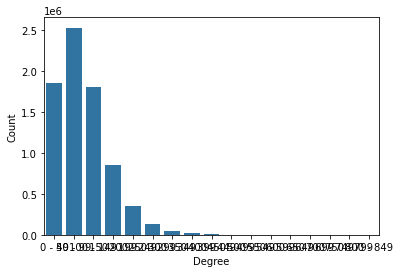

In [134]:
sns.barplot(data=bars, x = "Degree", y="Count", color=sns.color_palette()[0])